# Rental Price Development



## Context:
You, as a Data Scientist, have been approached by a Product Manager who is responsible for a platform designed for business customers who publish their properties on our platforms. He would like to create a new section on the platform that provides customers with valuable insights into the market trends, in order to help them make informed decisions. One of the components of this section is a dashboard that displays the development and forecast of rental prices of residential properties.
## Task:
Your task would be to develop a rental price forecasting model and prepare one or multiple graphs that could showcase the results. For the proof of concept you can focus only on residential properties in one location and forecast prices for the next year (2023).
## Data:
As the foundation for your forecasting model you are going to get a data set that includes prices of rental properties published on the platform over the last few years for multiple subcategories exactly for one location.
## Deliverables / outcome:
After finishing your research, you have to present the Product Manager your findings:

• problems / insights (if any) that were found in the historical data,

• forecasting itself with high level explanation:

    o what algorithm for the model was selected and why,

    o how it was evaluated, what kind of metrics were used and how they can be interpreted,

    o prototype visualisation.


In [1]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

/Users/rdyo/code/smg/smg_env/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/rdyo/code/smg/smg_env/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
# width = 20
# height = 8
# sns.set(rc = {'figure.figsize':(width, height)})

# Read the input data

In [3]:
df= pd.read_csv('forecasting.csv',parse_dates=['DATE'])

In [4]:
df.shape

(43544, 4)

In [5]:
df.sample(10)

,DATE,PRICE,SPACE,CATEGORIES
391,2020-05-26,1995.0,87.0,"APARTMENT, FLAT"
19135,2019-11-22,1350.0,91.0,APARTMENT
33868,2020-05-25,3410.0,NaN,"RETAIL, COMMERCIAL"
17199,2021-11-30,NaN,66.0,"APARTMENT, FLAT"
6560,2021-06-19,1850.0,85.0,"APARTMENT, FLAT"
40610,2020-10-12,NaN,11.0,"APARTMENT, STUDIO"
27533,2021-04-16,NaN,12.0,"APARTMENT, SINGLE_ROOM"
302,2018-02-23,1310.0,75.0,APARTMENT
12286,2019-05-13,2450.0,124.0,DUPLEX
32073,2019-12-17,1820.0,89.0,LOFT


In [6]:
print("Data from ",df['DATE'].min().date()," up to ",df['DATE'].max().date())

Data from  2018-01-01  up to  2021-12-31


# Duplicates

In [7]:
print("Data contains",df.duplicated().sum(),"duplicates")

Data contains 3489 duplicates


remove duplicates

In [8]:
df = df.drop_duplicates(keep='first')

In [9]:
df.shape

(40055, 4)

# Missing values

In [10]:
df[df['PRICE'].isna()].sample(5)

,DATE,PRICE,SPACE,CATEGORIES
16542,2019-02-15,NaN,NaN,PRACTICE
34791,2019-01-08,NaN,NaN,SHOP
11925,2021-02-19,NaN,111.0,"APARTMENT, ATTIC_FLAT"
42864,2021-12-02,NaN,18.0,"APARTMENT, FURNISHED_FLAT"
40759,2020-08-27,NaN,17.0,"APARTMENT, SINGLE_ROOM"


Missing values should be carefully studied, understood and filled with values. For simplicity, the rows with missing data are removed in this analysis

In [11]:
mask = df['PRICE'].isna() | df['SPACE'].isna() | df['CATEGORIES'].isna()
print("Number of rows with missing data:",df[mask].shape[0])

Number of rows with missing data: 11098


In [12]:
df = df[~mask]

# Outliers

Outliers are very interesting business cases and potentially might have a lot of value, e.g due to above average margin. 

However each of this cases needs to be carefully looked at and discuss with business stakeholders. 

## Categories with only few rows of data

In [13]:
print("Total number of categories: ",df['CATEGORIES'].nunique())

Total number of categories:  56


In [14]:
df['CATEGORY_N_DATES'] = df.groupby(['CATEGORIES'])['DATE'].transform('nunique')
print("Median of number of rows per category is",df['CATEGORY_N_DATES'].median())
print("Max of number of rows per category is",df['CATEGORY_N_DATES'].max(),"for category",df[df['CATEGORY_N_DATES']==df['CATEGORY_N_DATES'].max()]['CATEGORIES'].unique())
print("Number of categories with less than 21 rows:",df[df['CATEGORY_N_DATES']<21]['CATEGORIES'].nunique())

Median of number of rows per category is 677.0
Max of number of rows per category is 797 for category ['APARTMENT, FLAT']
Number of categories with less than 21 rows: 29


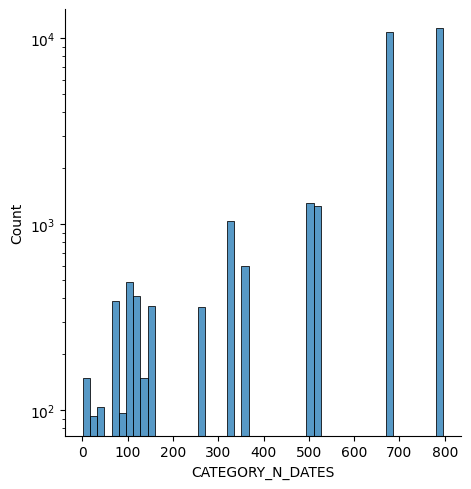

In [15]:
sns.displot(df, x="CATEGORY_N_DATES", bins=50)
plt.yscale('log')

As one can see from the above plot only few categories have records for more than 200 dates, for the rest number of rows in data is much smaller. 

Some categories have less than 21 dates. In our MVP solution we will ignore them.

In [16]:
print("Following ",df[df['CATEGORY_N_DATES']<10]['CATEGORIES'].nunique(),"categories will be removed due to lack of data:",df[df['CATEGORY_N_DATES']<10]['CATEGORIES'].unique())

Following  22 categories will be removed due to lack of data: ['RETAIL, PRACTICE' 'COMMERCIAL' 'HOUSE, VILLA' 'BACHELOR_FLAT' 'WORKSHOP'
 'HOUSE, MULTIPLE_DWELLING' 'SHOP' 'RESIDENTIAL_COMMERCIAL_BUILDING'
 'INDUSTRIAL_OBJECT' 'STORAGE_ROOM' 'CAFE_BAR, RESTAURANT'
 'RETAIL, HAIRDRESSER' 'RETAIL_SPACE, ATELIER' 'VILLA' 'ADVERTISING_AREA'
 'FACTORY' 'APARTMENT, BACHELOR_FLAT' 'RETAIL, STORAGE_ROOM'
 'UNDERGROUND_SLOT' 'CAFE_BAR, BAR' 'PRACTICE' 'COFFEEHOUSE']


In [17]:
df = df[df['CATEGORY_N_DATES']>=10]

## Extreme prices

In [18]:
df['CATEGORY_MEDIAN_PRICE'] = df.groupby(['CATEGORIES'])['PRICE'].transform('median')
df['PRICE_TO_CATEGORY_MEDIAN_PRICE'] = df['PRICE']/df['CATEGORY_MEDIAN_PRICE']
df['CATEGORY_N_PRICE'] = df.groupby(['CATEGORIES'])['PRICE'].transform('count')

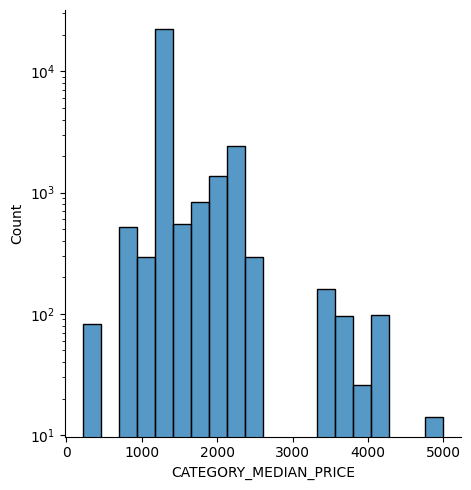

In [19]:
sns.displot(df, x="CATEGORY_MEDIAN_PRICE", bins=20)
plt.yscale('log')

Median price per category for most categories lies in the range from 0 to 5000.

In [20]:
print("Category with the highest median price:",df[df['CATEGORY_MEDIAN_PRICE']==df['CATEGORY_MEDIAN_PRICE'].max()]['CATEGORIES'].unique())

Category with the highest median price: ['RESTAURANT']


In [21]:
df.nlargest(5,'PRICE')

,DATE,PRICE,SPACE,CATEGORIES,CATEGORY_N_DATES,CATEGORY_MEDIAN_PRICE,PRICE_TO_CATEGORY_MEDIAN_PRICE,CATEGORY_N_PRICE
35117,2020-10-07,870150.0,59.0,"APARTMENT, FLAT",797,1360.0,639.816176,11297
38982,2020-10-08,52500.0,2100.0,OFFICE,133,1860.0,28.225806,149
39607,2019-11-04,30333.0,1300.0,OFFICE,133,1860.0,16.308065,149
19049,2021-10-05,28896.0,29.0,"APARTMENT, FLAT",797,1360.0,21.247059,11297
35062,2021-01-13,20300.0,327.0,"RETAIL, SHOP",47,1900.0,10.684211,67


Remove rows with price more than 100 times higher than category median price

In [22]:
df = df[df['PRICE_TO_CATEGORY_MEDIAN_PRICE']<100]

In [23]:
df.nsmallest(5,'PRICE')

,DATE,PRICE,SPACE,CATEGORIES,CATEGORY_N_DATES,CATEGORY_MEDIAN_PRICE,PRICE_TO_CATEGORY_MEDIAN_PRICE,CATEGORY_N_PRICE
30486,2018-08-10,1.0,6.0,APARTMENT,677,1370.0,0.000730,10856
7412,2021-11-11,26.0,40.0,"APARTMENT, FLAT",797,1360.0,0.019118,11297
38799,2020-04-30,70.0,8.0,HOBBY_ROOM,18,217.5,0.321839,18
38747,2020-10-29,80.0,10.0,HOBBY_ROOM,18,217.5,0.367816,18
1219,2020-04-24,100.0,13.0,"APARTMENT, FLAT",797,1360.0,0.073529,11297


Remove rows with price more than 100 times smalles than category median price

In [24]:
df = df[df['PRICE_TO_CATEGORY_MEDIAN_PRICE']>0.01]

In [25]:
df = df[['DATE','PRICE','SPACE','CATEGORIES']]

## Extreme spaces

In [26]:
df['CATEGORY_MEDIAN_SPACE'] = df.groupby(['CATEGORIES'])['SPACE'].transform('median')
df['SPACE_TO_CATEGORY_MEDIAN_SPACE'] = df['SPACE']/df['CATEGORY_MEDIAN_SPACE']
df['CATEGORY_N_SPACE'] = df.groupby(['CATEGORIES'])['SPACE'].transform('count')

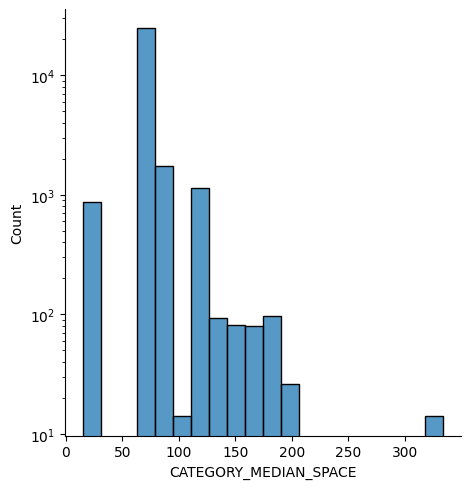

In [27]:
sns.displot(df, x="CATEGORY_MEDIAN_SPACE", bins=20)
plt.yscale('log')

In [28]:
print("Category with the highest median space:",df[df['CATEGORY_MEDIAN_SPACE']==df['CATEGORY_MEDIAN_SPACE'].max()]['CATEGORIES'].unique())

Category with the highest median space: ['RESTAURANT']


In [29]:
df.nlargest(5,'SPACE')

,DATE,PRICE,SPACE,CATEGORIES,CATEGORY_MEDIAN_SPACE,SPACE_TO_CATEGORY_MEDIAN_SPACE,CATEGORY_N_SPACE
38982,2020-10-08,52500.0,2100.0,OFFICE,90.0,23.333333,149
39607,2019-11-04,30333.0,1300.0,OFFICE,90.0,14.444444,149
37386,2020-11-13,5616.0,682.0,"RETAIL, COMMERCIAL",98.5,6.923858,14
39600,2019-12-06,15167.0,650.0,OFFICE,90.0,7.222222,149
39610,2020-02-19,12180.0,522.0,OFFICE,90.0,5.800000,149


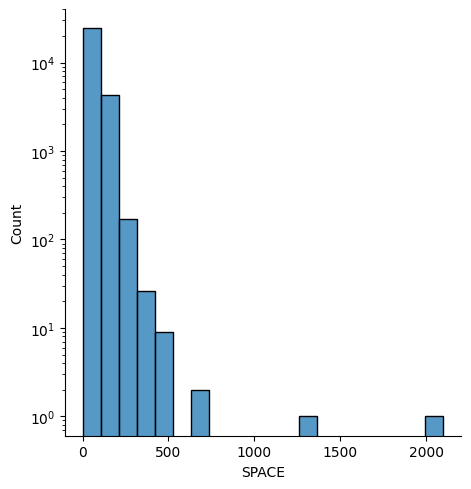

In [30]:
sns.displot(df, x="SPACE", bins=20)
plt.yscale('log')

Remove rows with very big space sizes

In [31]:
df = df[df['SPACE']<1000]

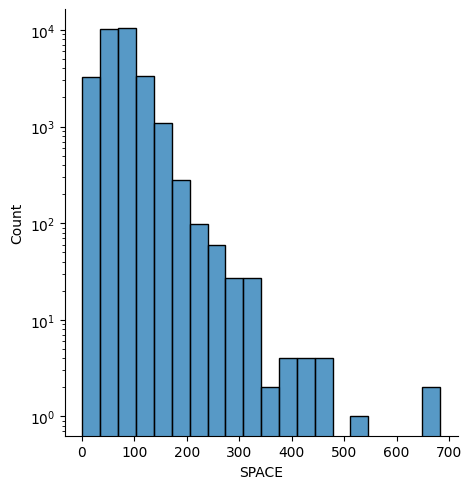

In [32]:
sns.displot(df, x="SPACE", bins=20)
plt.yscale('log')

In [33]:
# define the bin edges
bins = [0, 50, 100, 150, 200, 300, 400, 700]

# bin the age column
df['SPACE_binned'] = pd.cut(df['SPACE'], bins)

In [34]:
df = df[['DATE','PRICE','SPACE','SPACE_binned','CATEGORIES']]

#### Due to lack of time for this assignment we ignore outlier cases for the rest of the analysis, as well as in forecast model development

# Overall overview (without outliers)

In [35]:
df.shape

(28886, 5)

In [36]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The most interesting finding from the summary report:

- Price and Space are highly correlated

- CATEGORIES are imbalanced
  

# Time-series analysis

In [37]:
df = df.sort_values(by=['DATE'])
df['median_PRICE_CATEGORY_SPACE_binned_DATE'] = df.groupby(['CATEGORIES','SPACE_binned','DATE'])['PRICE'].transform('median')
df.head(10)

,DATE,PRICE,SPACE,SPACE_binned,CATEGORIES,median_PRICE_CATEGORY_SPACE_binned_DATE
12388,2018-01-01,3000.0,70.0,"(50, 100]",FURNISHED_FLAT,3000.0
1104,2018-01-02,1510.0,61.0,"(50, 100]",APARTMENT,1430.0
15931,2018-01-02,980.0,54.0,"(50, 100]",APARTMENT,1430.0
33094,2018-01-02,650.0,29.0,"(0, 50]",APARTMENT,700.0
30327,2018-01-02,2350.0,70.0,"(50, 100]",FURNISHED_FLAT,2350.0
32961,2018-01-02,2050.0,102.0,"(100, 150]",APARTMENT,2340.0
12133,2018-01-02,620.0,28.0,"(0, 50]",APARTMENT,700.0
29943,2018-01-02,1875.0,50.0,"(0, 50]",FURNISHED_FLAT,1875.0
29914,2018-01-02,8669.0,135.0,"(100, 150]",FURNISHED_FLAT,5489.5
33708,2018-01-02,10000.0,278.0,"(200, 300]",SINGLE_HOUSE,10000.0


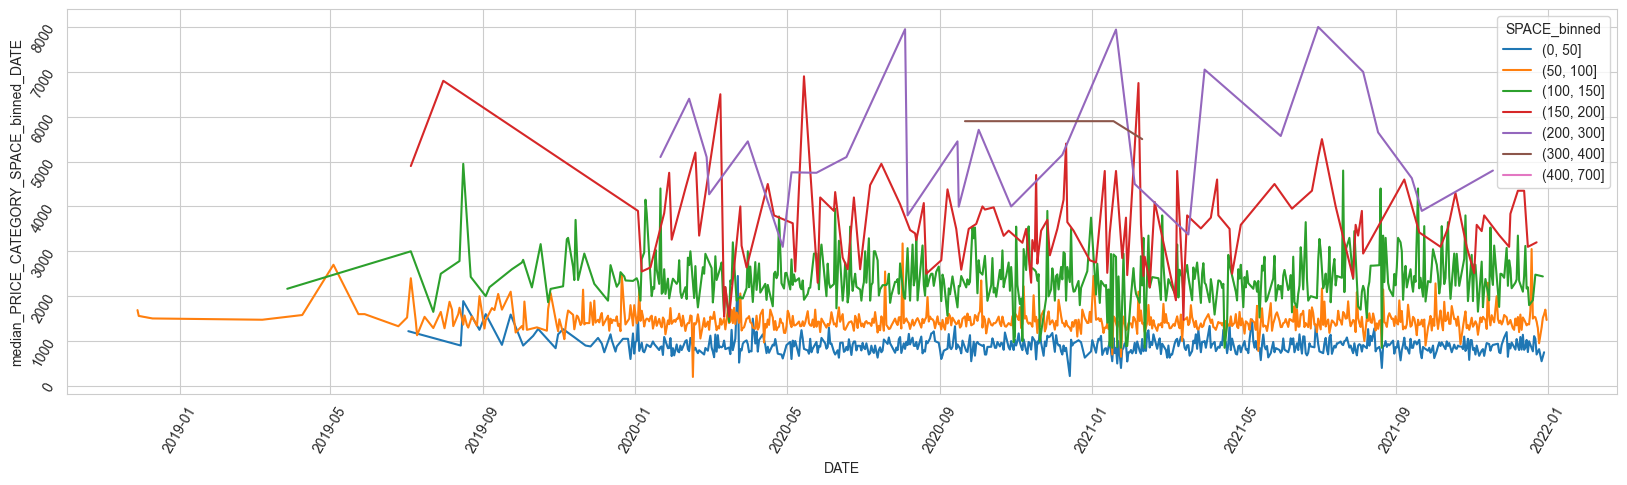

In [38]:
mask = df['CATEGORIES'].isin(['APARTMENT, FLAT'])
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax = sns.lineplot(x="DATE", y="median_PRICE_CATEGORY_SPACE_binned_DATE",
             hue='SPACE_binned',
             data=df[mask])
ax.tick_params (rotation = 60)
plt.show()

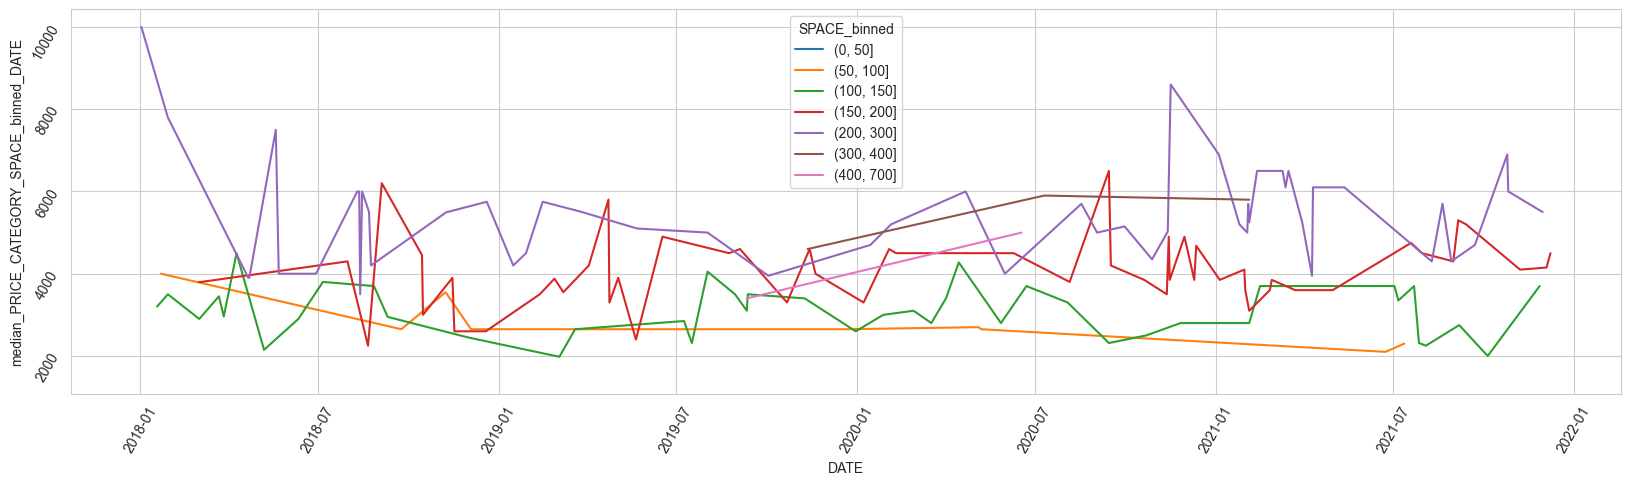

In [48]:
mask = df['CATEGORIES'].isin(['HOUSE, SINGLE_HOUSE'])
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax = sns.lineplot(x="DATE", y="median_PRICE_CATEGORY_SPACE_binned_DATE",
             hue='SPACE_binned',
             data=df[mask])
ax.tick_params (rotation = 60)
plt.show()

#### Observation: for "APARTMENT, FLAT" category median price per bin does not change much with time

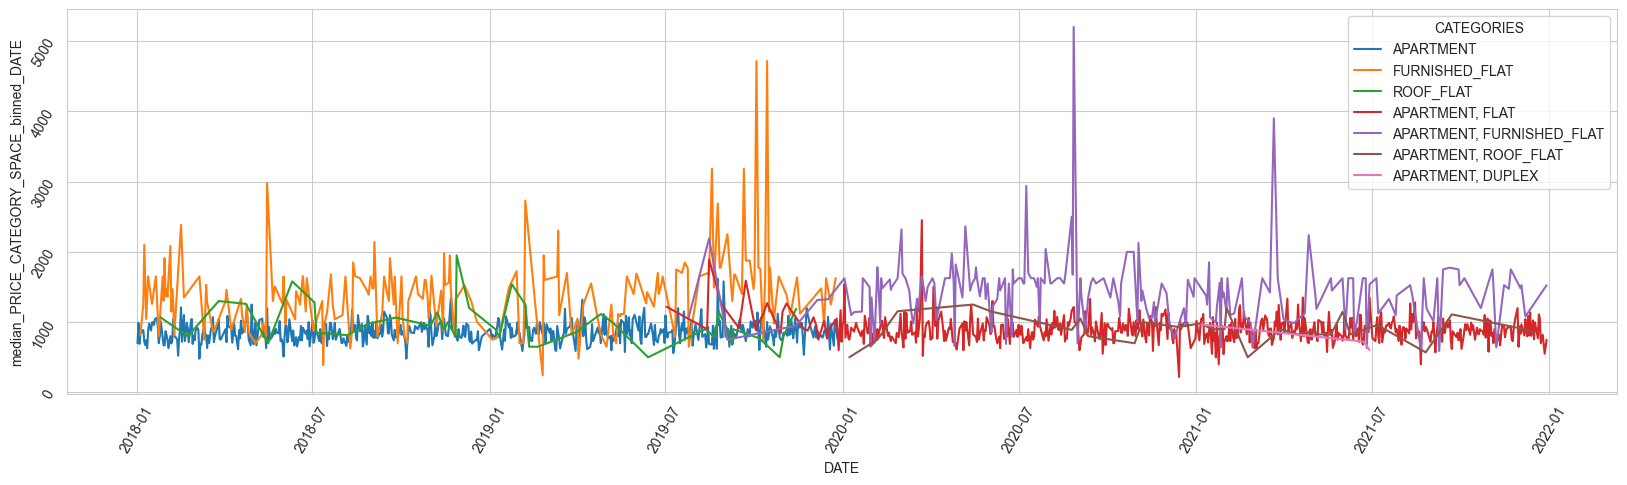

In [39]:
df['CATEGORY_N_DATES'] = df.groupby(['CATEGORIES'])['DATE'].transform('nunique')
mask = (df['SPACE']<50) & (df['CATEGORY_N_DATES']>200)
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax = sns.lineplot(x="DATE", y="median_PRICE_CATEGORY_SPACE_binned_DATE",
             hue='CATEGORIES',
             data=df[mask])
ax.tick_params (rotation = 60)
plt.show()

#### Observation: some categories seems to be renamed in the end of 2019, e.g APARTMENT -> "APARTMENT, FLAT"

## Categories merge

In [40]:
df_cat = df.groupby(['CATEGORIES']).agg({'DATE':['min','max']}).reset_index()

In [41]:
mask_1 = df_cat[('DATE','min')]>'2019-05-01'
df_cat[mask_1]

CATEGORIES       DATE           
                                         min        max
1                APARTMENT, ATTIC 2020-01-07 2021-12-21
2           APARTMENT, ATTIC_FLAT 2019-06-13 2021-12-20
4   APARTMENT, DUPLEX, MAISONETTE 2019-07-02 2021-12-09
7                 APARTMENT, LOFT 2020-01-02 2021-12-10
9          APARTMENT, SINGLE_ROOM 2020-01-08 2021-12-29
10              APARTMENT, STUDIO 2019-07-31 2021-12-15
11        APARTMENT, TERRACE_FLAT 2019-08-05 2021-11-19
19        HOUSE, BIFAMILIAR_HOUSE 2020-01-07 2021-09-24
20               HOUSE, ROW_HOUSE 2020-01-16 2021-12-27
21            HOUSE, SINGLE_HOUSE 2019-11-09 2021-12-08
25             RETAIL, COMMERCIAL 2020-01-17 2021-11-08
26                   RETAIL, SHOP 2019-12-20 2021-11-11
29                  SHOP, ATELIER 2019-12-10 2021-12-16

In [42]:
mask_2 = df_cat[('DATE','max')]<'2020-02-01'
df_cat[mask_2]

CATEGORIES       DATE           
                            min        max
0          APARTMENT 2018-01-02 2020-01-07
12           ATELIER 2018-06-09 2019-12-20
13             ATTIC 2018-01-08 2019-12-20
14        ATTIC_FLAT 2018-01-11 2019-12-12
15  BIFAMILIAR_HOUSE 2018-01-03 2019-10-02
16            DUPLEX 2018-01-02 2019-12-27
17    FURNISHED_FLAT 2018-01-01 2019-12-31
22              LOFT 2018-01-15 2019-12-20
27         ROOF_FLAT 2018-01-02 2020-01-08
28         ROW_HOUSE 2018-01-08 2019-12-13
30      SINGLE_HOUSE 2018-01-02 2019-12-19
31       SINGLE_ROOM 2018-01-31 2019-12-21
32            STUDIO 2018-01-02 2019-12-17
33      TERRACE_FLAT 2018-04-16 2019-12-10

In [43]:
map_dict = {'ATTIC': 'APARTMENT, ATTIC', 'ATTIC_FLAT': 'APARTMENT, ATTIC_FLAT', 'ATELIER': 'SHOP, ATELIER',
           'BIFAMILIAR_HOUSE':'HOUSE, BIFAMILIAR_HOUSE', 'DUPLEX':'APARTMENT, DUPLEX, MAISONETTE',
           'FURNISHED_FLAT':'APARTMENT, FURNISHED_FLAT', 'LOFT':'APARTMENT, LOFT','ROW_HOUSE':'HOUSE, ROW_HOUSE','SINGLE_HOUSE':'HOUSE, SINGLE_HOUSE',
           'SINGLE_ROOM':'APARTMENT, SINGLE_ROOM','STUDIO':'APARTMENT, STUDIO','TERRACE_FLAT':'APARTMENT, TERRACE_FLAT',
           'APARTMENT':'APARTMENT, FLAT', 'ROOF_FLAT':'APARTMENT, ROOF_FLAT'}
df['CATEGORIES'] = df['CATEGORIES'].replace(map_dict)

In [44]:
df_cat = df.groupby(['CATEGORIES']).agg({'DATE':['min','max']}).reset_index()
mask_2 = df_cat[('DATE','max')]<'2020-02-01'
df_cat[mask_2]

Empty DataFrame
Columns: [(CATEGORIES, ), (DATE, min), (DATE, max)]
Index: []

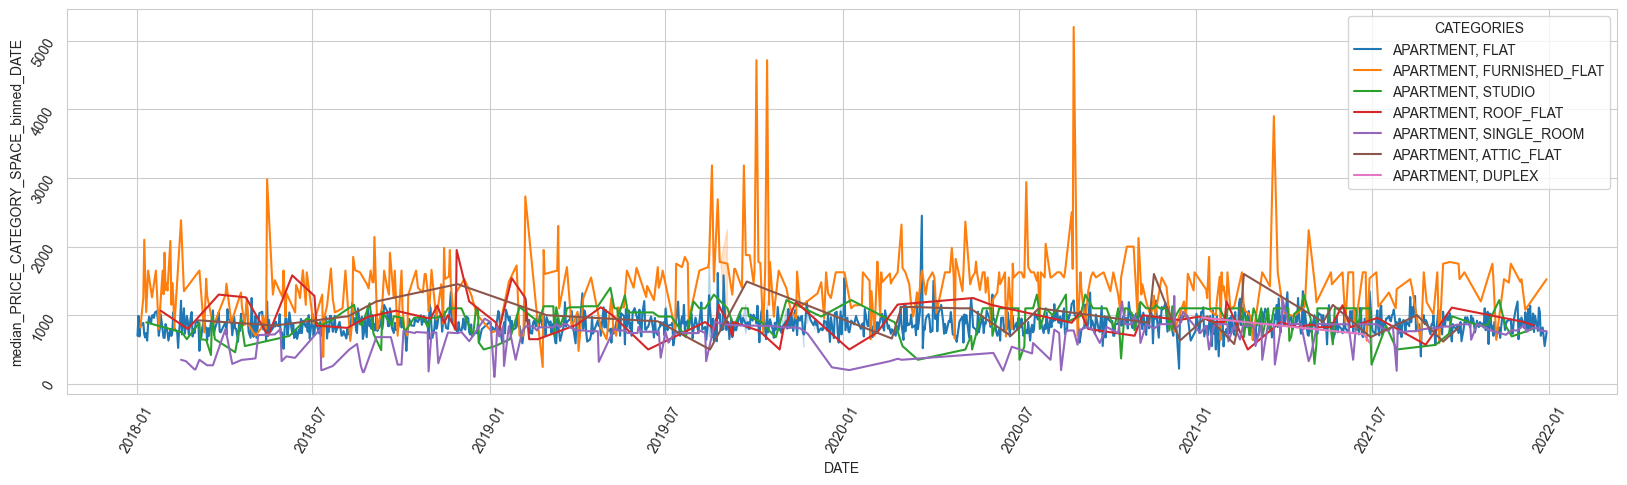

In [45]:
df['CATEGORY_N_DATES'] = df.groupby(['CATEGORIES'])['DATE'].transform('nunique')
mask = (df['SPACE']<50) & (df['CATEGORY_N_DATES']>200)
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax = sns.lineplot(x="DATE", y="median_PRICE_CATEGORY_SPACE_binned_DATE",
             hue='CATEGORIES',
             data=df[mask])
ax.tick_params (rotation = 60)
plt.show()

#### Observation: now most of categories presented during the entire time-frame

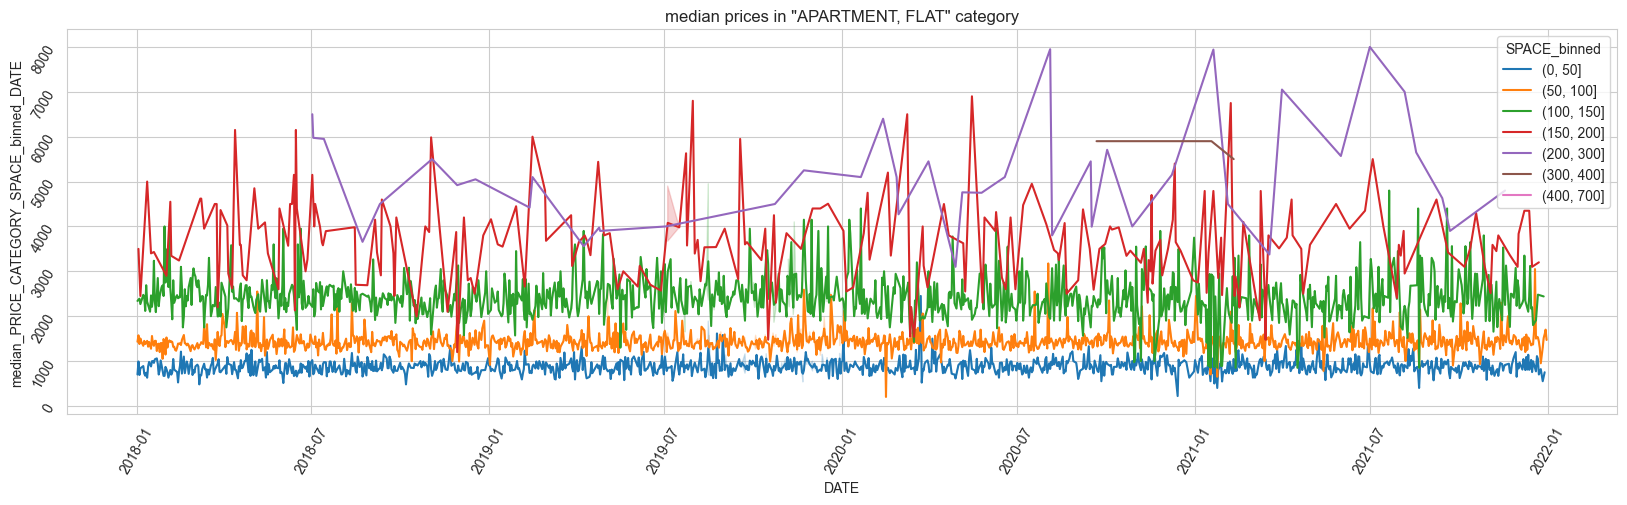

In [51]:
mask = df['CATEGORIES'].isin(['APARTMENT, FLAT'])
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax = sns.lineplot(x="DATE", y="median_PRICE_CATEGORY_SPACE_binned_DATE",
             hue='SPACE_binned',
             data=df[mask])
ax.set(title='median prices in "APARTMENT, FLAT" category')
ax.tick_params (rotation = 60)
plt.show()

In [46]:
print("Total number of categories: ",df['CATEGORIES'].nunique())

Total number of categories:  20


# Save cleaned dataset

In [47]:
df.to_csv('forecasting_cleaned.csv',index=False)